# 6.2 2次元入力2クラス分類

## 6.2.1 問題設定

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(seed=1)  
N = 100 
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
T2 = np.zeros((N, 2), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]])  
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]])  
Pi = np.array([0.4, 0.8, 1]) 
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])
T2[:, 0] = T3[:, 0]
T2[:, 1] = T3[:, 1] | T3[:, 2] 

In [3]:
print(X[:5,:])

[[-0.14173827  0.86533666]
 [-0.86972023 -1.25107804]
 [-2.15442802  0.29474174]
 [ 0.75523128  0.92518889]
 [-1.10193462  0.74082534]]


In [4]:
print(T2[:5,:])

[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


 '1'となってる列番号がクラスを表す．

上記の例なら，1,0,0,1,0

このように，目的変数ベクトル$t_n$のk番目の要素を1とする方法を，**1-of-K 符号化法**という．

In [5]:
print(T3[:5,:])#3クラス分類

[[0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]]


In [6]:
def show_data2(x, t):
    wk, K = t.shape
    c = [[.5, .5, .5], [1, 1, 1], [0, 0, 0]]
    for k in range(K):
        plt.plot(x[t[:, k] == 1, 0], x[t[:, k] == 1, 1],
                  linestyle='none', markeredgecolor='black',
                  marker='o', color=c[k], alpha=0.8)
    plt.grid(True)

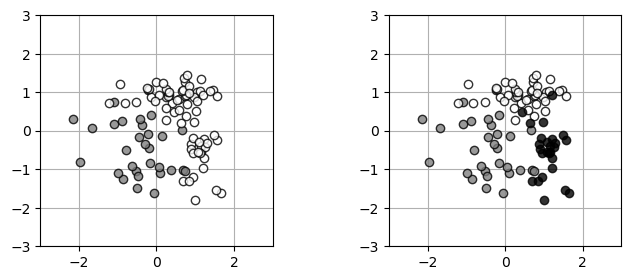

In [7]:
plt.figure(figsize=(7.5,3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
show_data2(X, T2)
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.subplot(1, 2, 2)
show_data2(X, T3)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

## 6.2.2 ロジスティック回帰モデル

1次元バージョンから2次元に拡張する．

$$
y=\sigma(a)\\
a=w_0x_0+w_1x_1+w_2
$$

モデルの出力yは，クラスが0である確率$P(t=0|x)$を近似するものとする．

In [8]:
def logistic2(x0, x1, w):
    y = 1 / (1 + np.exp(-(w[0] * x0 + w[1] * x1 + w[2])))
    return y

In [9]:
from mpl_toolkits.mplot3d import axes3d

In [10]:
def show3d_logistic2(ax, w):
    xn = 50
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    ax.plot_surface(xx0, xx1, y, color='blue', edgecolor='gray',
                    rstride=5, cstride=5, alpha=0.3)

In [11]:
def show_data2_3d(ax, x, t):
    c = [[.5, .5, .5], [1, 1, 1]]
    for i in range(2):
        ax.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], 1 - i,
                marker='o', color=c[i], markeredgecolor='black',
                linestyle='none', markersize=5, alpha=0.8)
    ax.view_init(elev=25, azim=-30)

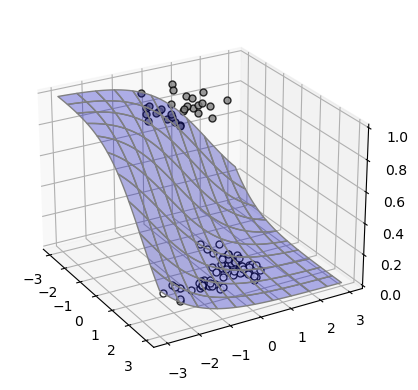

In [12]:
Ax = plt.subplot(1, 1, 1, projection='3d')
W=[-1, -1, -1] #w0,w1,w2
show3d_logistic2(Ax, W)
show_data2_3d(Ax,X,T2)
plt.show()

In [13]:
def show_contour_logistic2(w):
    xn = 30 
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    cont = plt.contour(xx0, xx1, y, levels=(0.2, 0.5, 0.8),
                       colors=['k', 'cornflowerblue', 'k'])
    cont.clabel(fmt='%.1f', fontsize=10)
    plt.grid(True)

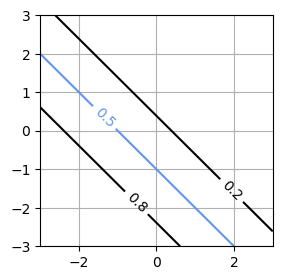

In [14]:
plt.figure(figsize=(3,3))
W=[-1, -1, -1]
show_contour_logistic2(W)
plt.show()

モデルの平均交差エントロピー誤差の式は1次元入力の時と同じものが使える．

$$
E(w)=-\frac{1}{N}\log P(T|X)=-\frac{1}{N}\sum^{N-1}_{n=0}\{t_n\log y_n+(1-t_n)\log (1-y_n)\}
$$

Tの0列目$T_{n0}$を$t_n$とおいて，1ならばクラス0，0ならばクラス1として扱う．

In [15]:
def cee_logistic2(w, x, t):
    X_n = x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    cee = 0
    for n in range(len(y)):
        cee = cee - (t[n, 0] * np.log(y[n]) +
                     (1 - t[n, 0]) * np.log(1 - y[n]))
    cee = cee / X_n
    return cee

パラメータの偏微分は以下のようになる．

$$
\frac{\partial E}{\partial w_0}=\frac{1}{N}\sum^{N-1}_{n=0}(y_n-t_n)x_{n0}\\
\frac{\partial E}{\partial w_1}=\frac{1}{N}\sum^{N-1}_{n=0}(y_n-t_n)x_{n1}\\
\frac{\partial E}{\partial w_2}=\frac{1}{N}\sum^{N-1}_{n=0}(y_n-t_n)
$$

In [16]:
def dcee_logistic2(w, x, t):
    X_n=x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    dcee = np.zeros(3)
    for n in range(len(y)):
        dcee[0] = dcee[0] + (y[n] - t[n, 0]) * x[n, 0]
        dcee[1] = dcee[1] + (y[n] - t[n, 0]) * x[n, 1]
        dcee[2] = dcee[2] + (y[n] - t[n, 0])
    dcee = dcee / X_n
    return dcee

In [17]:
W=[-1, -1, -1]
dcee_logistic2(W, X, T2)

array([ 0.10272008,  0.04450983, -0.06307245])

平均交差エントロピー誤差を最小にするパラメータを求めて，結果を表示する．

In [18]:
from scipy.optimize import minimize

In [19]:
def fit_logistic2(w_init, x, t):
    res = minimize(cee_logistic2, w_init, args=(x, t),
                   jac=dcee_logistic2, method="CG")
    return res.x

w0 = -3.70, w1 = -2.54, w2 = -0.28
CEE = 0.22


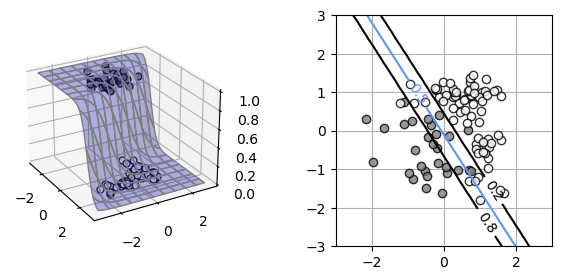

In [20]:
plt.figure(1, figsize=(7, 3))
plt.subplots_adjust(wspace=0.5)

Ax = plt.subplot(1, 2, 1, projection='3d')
W_init = [-1, 0, 0]
W = fit_logistic2(W_init, X, T2)
print("w0 = {0:.2f}, w1 = {1:.2f}, w2 = {2:.2f}".format(W[0], W[1], W[2]))
show3d_logistic2(Ax, W)
show_data2_3d(Ax, X, T2)
cee = cee_logistic2(W, X, T2)
print("CEE = {0:.2f}".format(cee))

Ax = plt.subplot(1, 2, 2)
show_data2(X, T2)
show_contour_logistic2(W)
plt.show()

# 6.3 2次元入力3クラス分類

## 6.3.1 3クラス分類ロジスティック回帰モデル

3クラスの分類問題では，3つのクラスの入力に対応する入力総和$a_k(k=0,1,2)$を考える．

$$
a_k=w_{k0}x_0+w_{k1}x_1+w_{k2}
$$

$w_{ki}$は，入力$x_i$からクラスkの入力総和を調整するパラメータである．

In [21]:
def logistic3(x0, x1, w):
    K = 3
    w = w.reshape((3, 3))
    n = len(x1)
    y = np.zeros((n, K))
    for k in range(K):
        y[:, k] = np.exp(w[k, 0] * x0 + w[k, 1] * x1 + w[k, 2])
    wk = np.sum(y, axis=1)
    wk = y.T / wk
    y = wk.T
    return y

In [22]:
W = np.array([1, 2, 3, 4 ,5, 6, 7, 8, 9])
y = logistic3(X[:3, 0], X[:3, 1], W)
print(np.round(y, 3))

[[0.    0.006 0.994]
 [0.965 0.033 0.001]
 [0.925 0.07  0.005]]


In [23]:
def cee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x[:, 0], x[:, 1], w)
    cee = 0
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            cee = cee - (t[n, k] * np.log(y[n, k]))
    cee = cee / X_n
    return cee

In [24]:
W = np.array([1, 2, 3, 4 ,5, 6, 7, 8, 9])
cee_logistic3(W, X, T3)

3.9824582404787288

In [25]:
def dcee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x[:, 0], x[:, 1], w)
    dcee = np.zeros((3, 3))  
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            dcee[k, :] = dcee[k, :] - (t[n, k] - y[n, k])* np.r_[x[n, :], 1]
    dcee = dcee / X_n
    return dcee.reshape(-1)

In [26]:
W = np.array([1, 2, 3, 4 ,5, 6, 7, 8, 9])
dcee_logistic3(W, X, T3)

array([ 0.03778433,  0.03708109, -0.1841851 , -0.21235188, -0.44408101,
       -0.38340835,  0.17456754,  0.40699992,  0.56759346])

In [27]:
def fit_logistic3(w_init, x, t):
    res = minimize(cee_logistic3, w_init, args=(x, t),
                   jac=dcee_logistic3, method="CG")
    return res.x

In [28]:
def show_contour_logistic3(w):
    xn = 30  
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    
    xx0, xx1 = np.meshgrid(x0, x1)
    y = np.zeros((xn, xn, 3))
    for i in range(xn):
        wk = logistic3(xx0[:, i], xx1[:, i], w)
        for j in range(3):
            y[:, i, j] = wk[:, j]
    for j in range(3):
        cont = plt.contour(xx0, xx1, y[:, :, j],
                             levels=(0.5, 0.9), 
                             colors=['cornflowerblue', 'k'])
        cont.clabel(fmt='%.1f', fontsize=9)
    plt.grid(True)

[[-3.2  -2.69  2.25]
 [-0.49  4.8  -0.69]
 [ 3.68 -2.11 -1.56]]
CEE = 0.23


/var/folders/tz/1gdvspds2t76hbmnyz9xhbyw0000gn/T/ipykernel_11958/1557344035.py:2: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(cee_logistic3, w_init, args=(x, t),


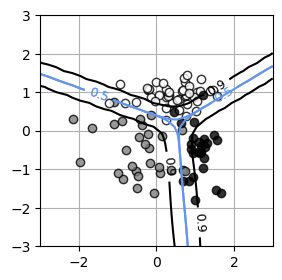

In [29]:
W_init = np.zeros((3, 3))
W = fit_logistic3(W_init, X, T3)
print(np.round(W.reshape((3, 3)),2))
cee = cee_logistic3(W, X, T3)
print("CEE = {0:.2f}".format(cee))

plt.figure(figsize=(3, 3))
show_data2(X, T3)
show_contour_logistic3(W)
plt.show()